# Mean truncation

In [89]:
import os
import torch
import numpy as np
import pandas as pd

# Path to the directory containing the embeddings files
directory = "embeddings"
files = [f for f in os.listdir(directory) if f.startswith("batch_") and f.endswith(".pt")]
files.sort(key=lambda x: int(x.split("_")[1].split(".")[0]))

# Load all embeddings and concatenate them into a single tensor
embeddings = []
for file in files:
    file_path = os.path.join(directory, file)
    embedding = torch.load(file_path)
    embeddings.append(embedding.mean(1)) # (batch size, sequence length, embedding dim) -> (batch size, embedding dim)

# Concatenate all tensors
embeddings = torch.cat(embeddings, dim=0).detach().numpy()
np.save(directory + "/embedding_tensor", embeddings)
embeddings.shape

/var/folders/nz/6cp76bzd2_b0frljxrh_r74w0000gn/T/ipykernel_20667/20634235.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embedding = torch.load(file_path)


(5588, 768)

# Sequence truncated global PCA

In [5]:
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.decomposition import PCA

# Path to the directory containing the embeddings files
directory = "embeddings"
files = [f for f in os.listdir(directory) if f.startswith("batch_") and f.endswith(".pt")]
files.sort(key=lambda x: int(x.split("_")[1].split(".")[0]))

# First PCA to reduce sequence length -> 1
# We'll collect all principal-component vectors across all files
all_pcs = []

for file in tqdm(files):
    file_path = os.path.join(directory, file)
    embedding = torch.load(file_path, weights_only=True)  # shape: (batch_size, seq_len, embedding_dim)
    
    batch_size = embedding.shape[0]
    seq_len = embedding.shape[1]
    embed_dim = embedding.shape[2]
    
    # We'll store the principal components for each sample in this batch
    pcs = []
    for i in range(batch_size):
        # shape (seq_len, embed_dim)
        sample = embedding[i].cpu().numpy()
        
        # PCA across the seq_len dimension -> 1 principal component in the original embedding space
        pca_seq = PCA(n_components=1)
        pca_seq.fit(sample)  # shape: (seq_len, embed_dim)
        
        # pca_seq.components_ has shape (1, embed_dim) for n_components=1
        # This is the principal direction in the original feature (embedding) space
        pc = pca_seq.components_[0]  # shape: (embed_dim,)
        pcs.append(pc)

    # Stack to get shape (batch_size, embed_dim)
    pcs = np.stack(pcs, axis=0)
    all_pcs.append(pcs)

# Concatenate all PCA-collapsed batches -> shape (N, embed_dim), where N is total across all batches
all_pcs = np.concatenate(all_pcs, axis=0)

# Second PCA on the embedding dimension -> 2
pca_embed = PCA(n_components=2)
pca_embeddings = pca_embed.fit_transform(all_pcs)  # shape: (N, 2)
#np.save(os.path.join(directory, "pca_embeddings.npy"), pca_embeddings)
pca_embeddings.shape

100%|██████████| 350/350 [01:16<00:00,  4.57it/s]


(5588, 2)

# Hierarchical PCA

In [102]:
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.decomposition import PCA

# Path to the directory containing the embeddings files
directory = "embeddings"
files = [f for f in os.listdir(directory) if f.startswith("batch_") and f.endswith(".pt")]
files.sort(key=lambda x: int(x.split("_")[1].split(".")[0]))

# Configurations
seq_pca_dim = 12    # Number of principal components to keep for the sequence dimension, preserves about 90% of information
final_pca_dim = 30  # Number of global PCA dimensions to reduce to

# Collect intermediate PCA-transformed data
all_intermediate_embeddings = []

for file in tqdm(files):
    file_path = os.path.join(directory, file)
    embedding = torch.load(file_path, weights_only=True)  # shape: (batch_size, seq_len, embedding_dim)

    batch_size = embedding.shape[0]
    seq_len = embedding.shape[1]
    embed_dim = embedding.shape[2]

    # Store the PCA-transformed sequence for the entire batch
    intermediate_batch = []
    for i in range(batch_size):
        # shape: (seq_len, embed_dim)
        sample = embedding[i].cpu().numpy()
        # shape: (embed_dim, seq_len)
        sample = sample.T

        # PCA across the sequence length dimension -> seq_pca_dim principal components
        pca_seq = PCA(n_components=seq_pca_dim)
        seq_transformed = pca_seq.fit_transform(sample)  # shape: (embed_dim, seq_pca_dim)

        # Flatten the reduced sequence embedding: shape (seq_pca_dim * embedding_dim,)
        intermediate_batch.append(seq_transformed.flatten())

    # Stack to get shape (batch_size, seq_pca_dim * embed_dim)
    intermediate_batch = np.stack(intermediate_batch, axis=0)
    all_intermediate_embeddings.append(intermediate_batch)

# Concatenate all intermediate PCA-collapsed batches -> shape (N, seq_pca_dim * embedding_dim)
all_intermediate_embeddings = np.concatenate(all_intermediate_embeddings, axis=0)

# Global PCA on the sequence-compressed embeddings -> final_pca_dim
pca_global = PCA(n_components=final_pca_dim)
pca_embeddings = pca_global.fit_transform(all_intermediate_embeddings)  # shape: (N, final_pca_dim)

# Save the final PCA-transformed embeddings
np.save(os.path.join(directory, "pca_embeddings.npy"), pca_embeddings)
pca_embeddings.shape

100%|██████████| 350/350 [02:19<00:00,  2.51it/s]


(5588, 30)

In [129]:
pca_seq.explained_variance_ratio_.sum(), pca_global.explained_variance_ratio_.sum()
pca_global.explained_variance_ratio_

array([0.20459254, 0.05971602, 0.01921128, 0.01789809, 0.01423955,
       0.01298136, 0.0119982 , 0.01121688, 0.01004734, 0.0090596 ,
       0.0080756 , 0.00794445, 0.00745439, 0.00686823, 0.00671401,
       0.00649655, 0.00615243, 0.00590807, 0.00574084, 0.00557331,
       0.00524395, 0.00516464, 0.00493555, 0.00487621, 0.00455986,
       0.00443784, 0.00427098, 0.00416504, 0.00402431, 0.00389037],
      dtype=float32)

# Hierarchical PCA with asyncio

In [56]:
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.decomposition import PCA
import asyncio

# Path to the directory containing the embeddings files
directory = "embeddings"
files = [f for f in os.listdir(directory) if f.startswith("batch_") and f.endswith(".pt")]
files.sort(key=lambda x: int(x.split("_")[1].split(".")[0]))

# Configurations
seq_pca_dim = 2  # Number of principal components to keep for the sequence dimension, preserves about 90% of information
final_pca_dim = 2  # Number of global PCA dimensions to reduce to

# Collect intermediate PCA-transformed data
all_intermediate_embeddings = []

async def process_file(file, loop):
    # Use run_in_executor to offload CPU-bound tasks to threads
    file_path = os.path.join(directory, file)
    embedding = await loop.run_in_executor(None, torch.load, file_path, {'weights_only': True})
    # shape: (batch_size, seq_len, embedding_dim)

    batch_size = embedding.shape[0]
    seq_len = embedding.shape[1]
    embed_dim = embedding.shape[2]

    # Store the PCA-transformed sequence for the entire batch
    intermediate_batch = []
    for i in range(batch_size):
        # shape: (seq_len, embed_dim)
        sample = embedding[i].cpu().numpy()
        # shape: (embed_dim, seq_len)
        sample = sample.T

        # PCA across the sequence length dimension -> seq_pca_dim principal components
        pca_seq = PCA(n_components=seq_pca_dim)
        seq_transformed = await loop.run_in_executor(None, pca_seq.fit_transform, sample)
        # shape: (embed_dim, seq_pca_dim)

        # Flatten the reduced sequence embedding: shape (seq_pca_dim * embedding_dim,)
        intermediate_batch.append(seq_transformed.flatten())

    # Stack to get shape (batch_size, seq_pca_dim * embed_dim)
    intermediate_batch = np.stack(intermediate_batch, axis=0)
    return intermediate_batch

async def main():
    loop = asyncio.get_event_loop()
    tasks = [process_file(file, loop) for file in files]
    # Use tqdm to show progress
    for task in tqdm(asyncio.as_completed(tasks), total=len(tasks)):
        intermediate_batch = await task
        all_intermediate_embeddings.append(intermediate_batch)

    # Concatenate all intermediate PCA-collapsed batches -> shape (N, seq_pca_dim * embedding_dim)
    all_intermediate_embeddings = np.concatenate(all_intermediate_embeddings, axis=0)

    # Global PCA on the sequence-compressed embeddings -> final_pca_dim
    pca_global = PCA(n_components=final_pca_dim)
    pca_embeddings = await loop.run_in_executor(None, pca_global.fit_transform, all_intermediate_embeddings)
    # shape: (N, final_pca_dim)

    # Save the final PCA-transformed embeddings
    np.save(os.path.join(directory, "pca_embeddings.npy"), pca_embeddings)
    print(pca_embeddings.shape)

# Run the async main function
if __name__ == "__main__":
    asyncio.run(main())

RuntimeError: asyncio.run() cannot be called from a running event loop

# Visualization

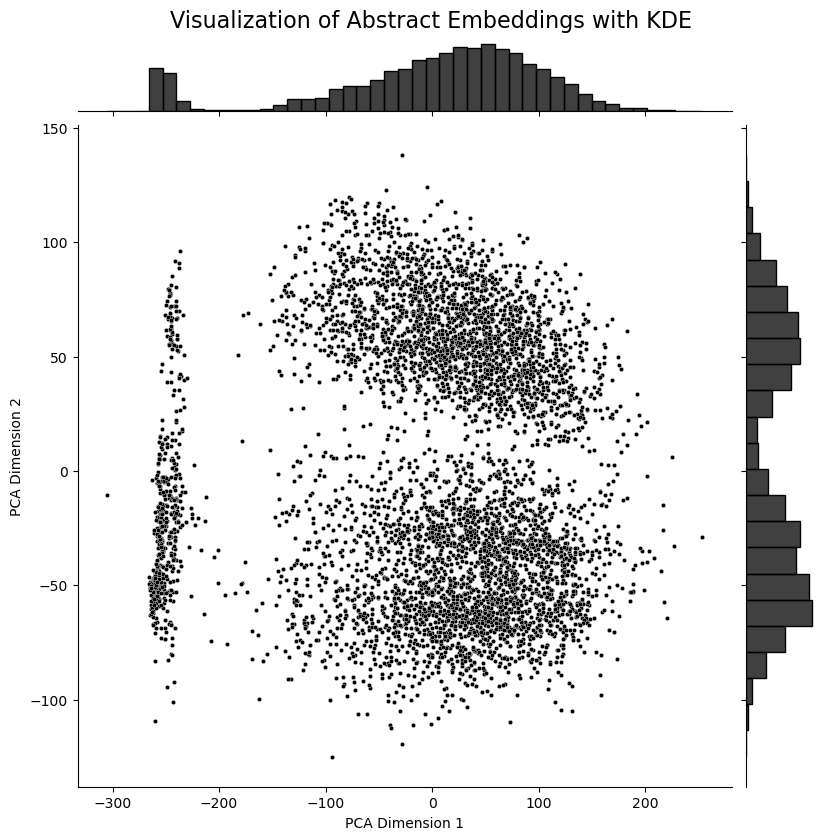

In [113]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load the embeddings
directory = "embeddings"
pca_embeddings = np.load(os.path.join(directory, "pca_embeddings.npy"))

sns.jointplot(
    x=pca_embeddings[:, 0],
    y=pca_embeddings[:, 1],
    kind="scatter",
    color="black",
    marginal_kws=dict(fill=True),
    s=10,
    height=8,
    ratio=8,
)

plt.suptitle('Visualization of Abstract Embeddings with KDE', fontsize=16, y=1.02)
plt.xlabel("PCA Dimension 1"), plt.ylabel("PCA Dimension 2")
plt.show()

Enter the index of the embedding you want to analyze:  735


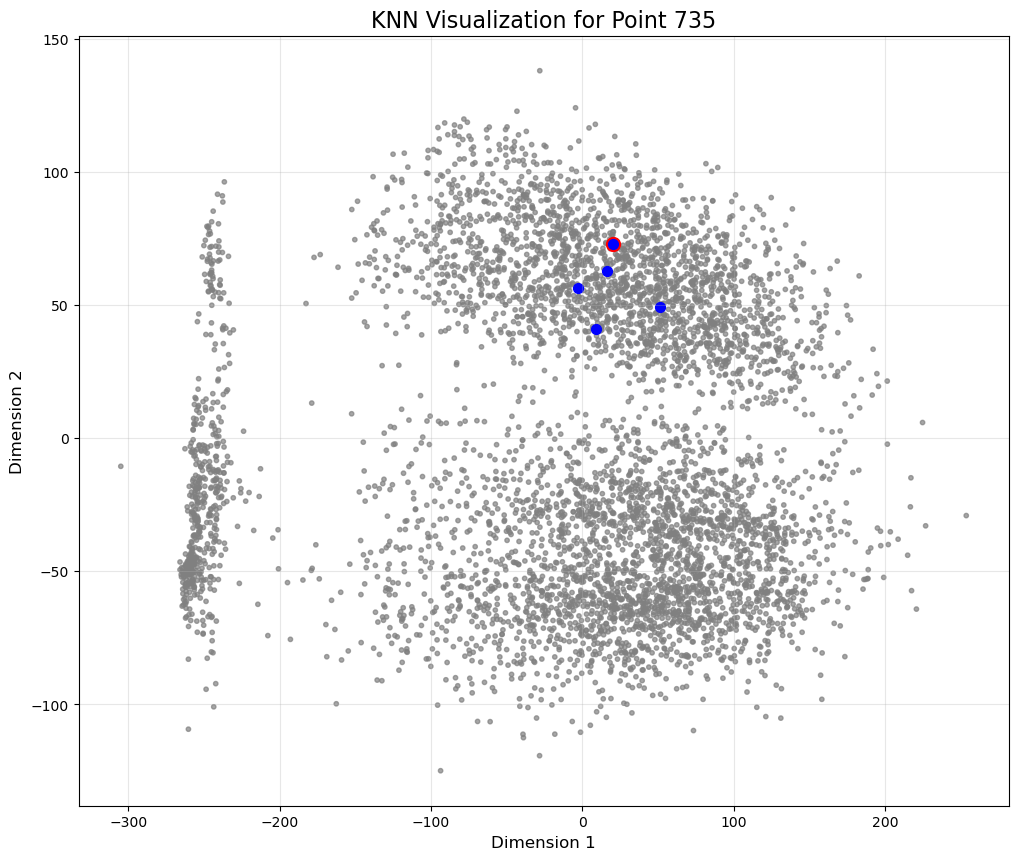


### Common Themes from KNN Abstracts:

After analyzing the abstracts, I've identified some common themes and elements that they share:

1. **Graphs and Networks**: Most of the papers deal with graphs, networks, or network structures in some way. They explore topics like graph generation, network clustering, edge weight prediction, and motif analysis.
2. **Machine Learning and Algorithms**: Many of the papers propose new algorithms or methods for solving specific problems, such as Q-learning, generative models, clustering algorithms, and neural network-based approaches.
3. **Data-Driven Approaches**: The papers often rely on data-driven approaches, using real-world datasets or simulations to validate their methods and models.
4. **Complex Systems**: The research focuses on complex systems, such as built environments, temporal graphs, and multi-layer networks, which require sophisticated models and algorithms to analyze and understand.
5. **Optimization and Performance Improvement**: Se

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from sklearn.neighbors import NearestNeighbors
from groq import Groq
from dotenv import load_dotenv
import os

# Load the Groq API key
load_dotenv()
client = Groq(api_key=os.environ.get("GROQ_API_KEY"))
model = "llama-3.3-70b-versatile"

# Function to extract themes from abstracts
def extract_themes(abstracts, temperature=0, max_tokens=8000, model=model):
    chat_history = [
        {"role": "system", "content": "You are an AI assistant skilled at identifying common themes in text."},
        {"role": "user", "content": "Here are several abstracts from scientific papers:"},
        {"role": "user", "content": "\n".join(abstracts)},
        {"role": "user", "content": "What do they share in common?"}
    ]

    response = client.chat.completions.create(
        messages=chat_history,
        model=model,
        temperature=temperature,
        max_tokens=max_tokens,
    )
    
    themes = response.choices[0].message.content
    return themes

# Load the abstracts
df = pd.read_csv("arxiv_abstracts.csv")

# Create a DataFrame of the PCA
embedding_df = pd.DataFrame(pca_embeddings, columns=[f"dim_{i}" for i in range(1, 31)])
embedding_df['index'] = embedding_df.index  # Add an index column for user selection

# Define an interactive function
def interactive_knn_plot(selected_index, k=5):
    """
    Perform KNN based on user-selected point, visualize with t-SNE, and extract common themes from neighbors.
    """
    # Perform KNN
    knn_model = NearestNeighbors(n_neighbors=k, metric='cosine')
    knn_model.fit(pca_embeddings)
    distances, indices = knn_model.kneighbors([pca_embeddings[selected_index]])

    # Update the DataFrame for visualization
    embedding_df['type'] = 'All Embeddings'
    embedding_df.loc[selected_index, 'type'] = 'Selected Embedding'
    for idx in indices[0]:
        embedding_df.loc[idx, 'type'] = 'KNN Embedding'

    # Visualize with Matplotlib
    plt.figure(figsize=(12, 10))  # Large figure size
    plt.scatter(
        embedding_df['dim_1'], embedding_df['dim_2'], 
        c=embedding_df['type'].map({'All Embeddings': 'gray', 'Selected Embedding': 'red', 'KNN Embedding': 'blue'}),
        alpha=0.7, s=10, label="All Embeddings"
    )
    plt.scatter(
        embedding_df.loc[selected_index, 'dim_1'], embedding_df.loc[selected_index, 'dim_2'],
        c='red', s=100, label='Selected Embedding'
    )
    for idx in indices[0]:
        plt.scatter(
            embedding_df.loc[idx, 'dim_1'], embedding_df.loc[idx, 'dim_2'], 
            c='blue', s=50, label='KNN Embedding'
        )
    plt.title(f"KNN Visualization for Point {selected_index}", fontsize=16)
    plt.xlabel("Dimension 1", fontsize=12)
    plt.ylabel("Dimension 2", fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

    # Extract themes from KNN abstracts using LLM
    k_titles = df.iloc[indices[0]]['Title'].tolist()
    k_abstracts = df.iloc[indices[0]]['Abstract'].tolist()
    themes = extract_themes(k_abstracts)

    # Print the extracted themes
    print("\n### Common Themes from KNN Abstracts:\n")
    print(themes)
    
    # Print the titles and abstracts of KNN neighbors
    print("\n### Titles and Abstracts of KNN Neighbors:\n")
    for i, (title, abstract) in enumerate(zip(k_titles, k_abstracts)):
        print(f"Neighbor {i+1}:")
        print(f"Title: {title}")
        print(f"Abstract: {abstract}\n")
        print("-" * 80)

# Let the user select an arbitrary point
user_selected_index = int(input("Enter the index of the embedding you want to analyze: "))
interactive_knn_plot(user_selected_index, k=5)